## <프로젝트 유형: Multi-Step LSTM Time Series Forecasting>
* windows개념 이용해서 univariate time series forecasting의 방법으로 해결해보고자 함

In [1]:
# Runned_by_JupyterLab


# 1. V1과 비교하여 Version_2에 반영된 내용(+ 성능 향상을 위해 필요하다고 어느 정도 검증한 요소)
# loss값은 모델 층이 어떻게 쌓이느냐에 의해 가장 크게 영향을 받는다. 즉, 나머지 요인들은 부차적. 모델 구축할 때 unit수 원하는 퍼포먼스 유형에 따라 잘 설정해주는 것이 예측에 있어 가장 중요하다고 해도 과언이 아니다.
# bidirectional은 시계열 에측에서 잘 쓰이지 않는다. lstm이 시계열 예측에 많이 쓰인다.
# window_size 설정은 생각보다 중요한 요소가 아니었다. 모델은 완전 똑같고 window크기만 60과 180으로 달리해보았지만 각 17593점과 16908점이 나옴. 700점 정도의 차이인데 내 예상보다는 크지 않았다.
# 당연한 말일 수 있으나 모델의 성능은 모델이 가지는 파라미터의 개수에 비례한다!!!
# activation(활성화 함수) relu -> tanh. rnn계열 모델에서는 하이퍼볼릭 탄젠트를 활성화 함수로 사용해야 한다. relu는 학습 자체가 불안정해진다고 한다. tanh는 gradient vanishing문제가 있다고 알려져 있으나 lstm은 이러한 장기의존성 문제를 LSTM 셀 사이에서만 공유되는 셀 상태를 이용하여 극복한다고 알려져 있다. 즉 과거 시점의 입력값이 현재와 멀어져도 문제를 충분히 풀 수 있다.
# 매수 기준가를 1.10으로 잡든 1.08로 잡든 1.13으로 잡든 데이콘 제출시 얻은 점수는 같았다.
# 모델을 함수로 정의한 뒤 각 sample_id 학습할 때마다 호출하여 이전 sample의 학습과정에서 조정된 파라미터에 다음 sample의 학습이 영향받지 않도록 함
# model.fit( *** , shuffle= True) <- 영향은 미미하다.
# 각 sample_id마다 test_x데이터로 학습할 때, 학습 이후 줄어든 최종 loss값과 sample_id 출력하도록 설정
# fit에서의 callbacks에 들어가는 인잣값들은 사실 학습에 막 큰 영향을 주진 않는다.
## 1) reduceLROnplateau(factor= 0.9, patience = 5) 이랑 learningrateScheduler은 또이또이하다.
## 2) earlystopping(patience = 10)
# 애초에 입력값이 많이 없는 편이니 dropout는 절대 지양.
# batch_size와 딥러닝 성능 간의 상관관계는 명확하지 않다. batch_size = 32, 64같은 미니배치를 많이 사용한다. 작은 배치를 사용할 수록 메모리 사용이 덜하고 큰 배치를 사용할 수록 학습이 안정적으로 이루어진다. batch_size는 메모리가 감당 가능한 한 크게 잡는게 좋다. batch_size 수가 클수록 학습이 빨라지는 장점이 있음. 대신 학습이 잘 안이루어지는 경우엔 batch_size 를 낮게 조정.
# optimizer = adam은 momentum과 rmsprop을 합친 느낌이다. 시계열 예측에서도 아담을 가장 흔하게 이용하는 듯하다.


# 2. Trials에서 시도해 볼 내용
# train 데이터 학습한 모델 앙상블
# Sarima 모델
# NLP 217p bidirectional layer추가 혹은 그냥 LSTM Layer 추가


# 3. 확실하지 않은 아이디어들
# 시가에 임의의 상수 곱해서 증폭된 값으로 입력해보기

---

In [2]:
#Import Library
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Dropout, Bidirectional#,Reshape, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read Data
data_path = '../Big_Data/[DACON]Bit_Trader'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [4]:
# 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

# 2차원 DF LSTM으로 학습하기 위해 3차원으로 변환시키기
train_x_array = df2d_to_array3d(train_x_df)   #(1380, 1380, 10)
train_y_array = df2d_to_array3d(train_y_df)   #(1380, 120, 10)
test_x_array = df2d_to_array3d(test_x_df)     #(529, 1380, 10)

In [5]:
# 모델 구성(op1: many-to-one model, op2: many-to-many model(output 모양 바꾸기, return_sequences = True, Window이동 단위 1에서 output 크기로 변경))
# LSTM에 return_sequence=True가 주어지고 Bidirectional이면서 TimeDistributed() 함수가 사용되면 양방향 many-to-many 유형이 된다.https://m.blog.naver.com/chunjein/221589656211
# TimeDistributed() 함수 사용: 모델 layer에 model.add(TimeDistributed(Dense(1, activation='sigmoid')))추가

def build_model():
    seq_len = 120
    model = Sequential()
    # 첫 번째 layer에서 LSTM()매서드 안의 stateful = True는 오히려 다운 퍼포먼스 될 수 있음
    model.add(LSTM(50, activation='tanh', return_sequences= True, input_shape = [seq_len, 1])) 
#     model.add(Bidirectional(LSTM(50, activation='tanh', dropout=0.50, recurrent_dropout=0.25)))
    model.add(LSTM(50, activation= 'tanh'))
    model.add(Dense(1))  #120개의 open값 입력되어 121번째 open값 '하나' 예측   
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    
    return model

In [6]:
build_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [9]:
# LearningRateScheduler(scheduler) 구현

# from tensorflow.keras.callbacks import LearningRateScheduler
# # LearningRateScheduler 함수 생성 (epoch이 5이하면 그대로 lr 유지, 아닐시 lr 조정)
# def scheduler(epoch, learning_rate):
#     if epoch < 5:
#         return learning_rate
#     else:
#         return learning_rate * tf.math.exp(-0.1)
# lr = LearningRateScheduler(scheduler)

In [ ]:
# test_x_array에 대한 Auto_Regressive한 Prediction 및 valid_pred_array에 예측 결과 기록

# 1) test_pred_array{예측값 모아두는 3차원 배열(120*1 2차원 배열 529개)} 만들기
test_pred_array = np.zeros([len(test_x_array), 120, 1])

# 2) early_stoppage & reduceLR 정의: https://www.dacon.io/competitions/official/235709/codeshare/2453?page=1&dtype=recent 참고)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 10, mode = 'auto')
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9, patience= 5, mode = 'auto', mindelta = 0.0001, min_lr=0)

# 3) test_x_array로 시계열 Windows 만들기 -> 데이터셋 구성 -> 모델 학습 ||| 예측 -> test_pred_array에 기록 -> window_3d의 첫번째 값 삭제 -> test_pred_array와 window_3d 병합 -> model.predict()에 넣어 예측 -> ***
ep = 30
bs = 120
# idx에 해당하는 샘플 529개 학습: for loop 529번 돌아감
for idx in tqdm(range(test_x_array.shape[0])):  # 529번
    seq_len = 120
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(test_x_array[idx, :, 1][index: index + sequence_length])

    # x_test, y_test 데이터셋 구성
    windows = np.array(windows)  # 1329 * 121의 2차원 배열
    x_test = windows[:, :-1]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = windows[:, -1]
    
    model = build_model()
    history = model.fit(x_test, y_test, epochs= ep, batch_size= bs, verbose=0, shuffle = True, callbacks=[early_stop, reduceLR])
# shuffle= True 효과 있을까? 미약하게나마 효과 있음. https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])
#     print('mse : ', history.history['mse'][-1])  #<- model.compile()의 metrics인자값으로 설정된 값을 추가로 출력해 주고 싶다면!
    print('lr : ', round(model.optimizer.lr.numpy(), 5))  #<-조정된 학습률 출력

    # test_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]  # windows.shape (1259, 121), window.shape (120, )
    window_3d = np.reshape(window, (1, window.shape[0], 1))  # (1, 120, 1)
    for m in range(120):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 test_pred_array에 기록
        test_pred_array[idx, m, :] = pred

        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = test_pred_array[idx, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # test_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

  0%|          | 0/529 [00:00<?, ?it/s]

sample_id :  0 번
loss :  0.00027520135771838257


  0%|          | 1/529 [00:26<3:56:34, 26.88s/it]

sample_id :  1 번
loss :  0.00035938580859895585


  0%|          | 2/529 [00:46<3:19:25, 22.71s/it]

sample_id :  2 번
loss :  0.0032925091264436553


  1%|          | 3/529 [01:07<3:09:52, 21.66s/it]

sample_id :  3 번
loss :  0.0018174360050191782


  1%|          | 4/529 [01:28<3:07:18, 21.41s/it]

sample_id :  4 번
loss :  0.00025449069930226454


  1%|          | 5/529 [01:48<3:02:52, 20.94s/it]

sample_id :  5 번
loss :  0.001070194649569264


  1%|          | 6/529 [02:08<2:59:10, 20.56s/it]

sample_id :  6 번
loss :  0.0007281963494044119


  1%|▏         | 7/529 [02:28<2:58:20, 20.50s/it]

sample_id :  7 번
loss :  0.0012895941539764451


  2%|▏         | 8/529 [02:48<2:55:37, 20.23s/it]

sample_id :  8 번
loss :  0.0006629230699692783


  2%|▏         | 9/529 [03:07<2:54:02, 20.08s/it]

sample_id :  9 번
loss :  0.0014998992493359862


  2%|▏         | 10/529 [03:27<2:53:12, 20.02s/it]

sample_id :  10 번
loss :  0.0004156447958907244


  2%|▏         | 11/529 [03:47<2:52:26, 19.97s/it]

sample_id :  11 번
loss :  0.0012017007782349602


  2%|▏         | 12/529 [04:08<2:54:01, 20.20s/it]

sample_id :  12 번
loss :  0.00031197838803972955


  2%|▏         | 13/529 [04:28<2:53:03, 20.12s/it]

sample_id :  13 번
loss :  0.0004187343379325804


  3%|▎         | 14/529 [04:48<2:52:30, 20.10s/it]

sample_id :  14 번
loss :  0.0007625902270398164


  3%|▎         | 15/529 [05:08<2:51:25, 20.01s/it]

sample_id :  15 번
loss :  0.0005615310544833079


  3%|▎         | 16/529 [05:28<2:51:40, 20.08s/it]

sample_id :  16 번
loss :  0.0003550854017602974


  3%|▎         | 17/529 [05:48<2:52:14, 20.18s/it]

sample_id :  17 번
loss :  0.002239880397452768


  3%|▎         | 18/529 [06:08<2:51:47, 20.17s/it]

sample_id :  18 번
loss :  0.0006626701609189367


  4%|▎         | 19/529 [06:28<2:48:58, 19.88s/it]

sample_id :  19 번
loss :  0.0015233412030470322


  4%|▍         | 20/529 [06:48<2:49:03, 19.93s/it]

sample_id :  20 번
loss :  0.0011139155113647934


  4%|▍         | 21/529 [07:08<2:48:53, 19.95s/it]

sample_id :  21 번
loss :  0.002387455999858624


  4%|▍         | 22/529 [07:28<2:49:45, 20.09s/it]

sample_id :  22 번
loss :  0.0004655105959262693


  4%|▍         | 23/529 [07:48<2:50:04, 20.17s/it]

sample_id :  23 번
loss :  0.002709591072171074


  5%|▍         | 24/529 [08:08<2:47:18, 19.88s/it]

sample_id :  24 번
loss :  0.0005082668720811496


  5%|▍         | 25/529 [08:29<2:49:38, 20.20s/it]

sample_id :  25 번
loss :  0.002873742978278669


  5%|▍         | 26/529 [08:48<2:48:29, 20.10s/it]

sample_id :  26 번
loss :  0.0020807017821883687


  5%|▌         | 27/529 [09:07<2:43:32, 19.55s/it]

sample_id :  27 번
loss :  0.0012786244744038455


  5%|▌         | 28/529 [09:27<2:44:14, 19.67s/it]

sample_id :  28 번
loss :  0.002671937228345428


  5%|▌         | 29/529 [09:46<2:44:02, 19.68s/it]

sample_id :  29 번
loss :  0.0003394209273313738


  6%|▌         | 30/529 [10:05<2:40:39, 19.32s/it]

sample_id :  30 번
loss :  0.0003531319003471198


  6%|▌         | 31/529 [10:25<2:41:18, 19.44s/it]

sample_id :  31 번
loss :  0.0003313485853534156


  6%|▌         | 32/529 [10:43<2:38:36, 19.15s/it]

sample_id :  32 번
loss :  0.0010436863790660492


  6%|▌         | 33/529 [11:02<2:39:04, 19.24s/it]

sample_id :  33 번
loss :  0.0009696697904558215


  6%|▋         | 34/529 [11:23<2:40:56, 19.51s/it]

sample_id :  34 번
loss :  0.0005421079875072102


  7%|▋         | 35/529 [11:41<2:37:57, 19.19s/it]

sample_id :  35 번
loss :  0.002276452231783837


  7%|▋         | 36/529 [12:01<2:39:14, 19.38s/it]

sample_id :  36 번
loss :  0.0010223000275593982


  7%|▋         | 37/529 [12:19<2:37:01, 19.15s/it]

sample_id :  37 번
loss :  0.0016601904747730995


  7%|▋         | 38/529 [12:40<2:39:12, 19.46s/it]

sample_id :  38 번
loss :  0.0006430933328354294


  7%|▋         | 39/529 [12:58<2:35:51, 19.08s/it]

sample_id :  39 번
loss :  0.0004463752772967162


  8%|▊         | 40/529 [13:18<2:37:54, 19.38s/it]

sample_id :  40 번
loss :  0.0009538832995700306


  8%|▊         | 41/529 [13:36<2:35:19, 19.10s/it]

sample_id :  41 번
loss :  0.0006002939975287135


  8%|▊         | 42/529 [13:57<2:38:01, 19.47s/it]

sample_id :  42 번
loss :  0.0004220078121606302


  8%|▊         | 43/529 [14:15<2:35:13, 19.16s/it]

sample_id :  43 번
loss :  0.00033025768333254493


  8%|▊         | 44/529 [14:35<2:37:15, 19.45s/it]

sample_id :  44 번
loss :  0.004308513633099054


  9%|▊         | 45/529 [14:54<2:34:24, 19.14s/it]

sample_id :  45 번
loss :  0.00032736326830341047


  9%|▊         | 46/529 [15:12<2:32:19, 18.92s/it]

sample_id :  46 번
loss :  0.0005427791365397158


  9%|▉         | 47/529 [15:32<2:35:20, 19.34s/it]

sample_id :  47 번
loss :  0.0002827541039255392


  9%|▉         | 48/529 [15:51<2:32:56, 19.08s/it]

sample_id :  48 번
loss :  0.000627069435231432


  9%|▉         | 49/529 [16:11<2:35:26, 19.43s/it]

sample_id :  49 번
loss :  0.0009545809269854629


  9%|▉         | 50/529 [16:30<2:32:38, 19.12s/it]

sample_id :  50 번
loss :  0.001392318505602959


 10%|▉         | 51/529 [16:50<2:36:09, 19.60s/it]

sample_id :  51 번
loss :  0.0007377003572549822


 10%|▉         | 52/529 [17:09<2:33:16, 19.28s/it]

sample_id :  52 번
loss :  0.0002383927409797892


 10%|█         | 53/529 [17:28<2:32:52, 19.27s/it]

sample_id :  53 번
loss :  0.00037252568958639343


 10%|█         | 54/529 [17:51<2:40:27, 20.27s/it]

sample_id :  54 번
loss :  0.0008461787756510238


 10%|█         | 55/529 [18:10<2:37:42, 19.96s/it]

sample_id :  55 번
loss :  0.0008940264391043387


 11%|█         | 56/529 [18:32<2:41:20, 20.47s/it]

sample_id :  56 번
loss :  0.0011471793623463599


 11%|█         | 57/529 [18:50<2:36:04, 19.84s/it]

sample_id :  57 번
loss :  0.000568575793283609


 11%|█         | 58/529 [19:09<2:33:49, 19.60s/it]

sample_id :  58 번
loss :  0.0004638237192347643


 11%|█         | 59/529 [19:31<2:38:29, 20.23s/it]

sample_id :  59 번
loss :  0.00041109890640233187


 11%|█▏        | 60/529 [19:50<2:35:04, 19.84s/it]

sample_id :  60 번
loss :  0.004255675415954507


 12%|█▏        | 61/529 [20:08<2:32:20, 19.53s/it]

sample_id :  61 번
loss :  0.0009220029451944248


 12%|█▏        | 62/529 [20:30<2:35:51, 20.02s/it]

sample_id :  62 번
loss :  0.0012808652437307573


 12%|█▏        | 63/529 [20:48<2:32:49, 19.68s/it]

sample_id :  63 번
loss :  0.003243322151130904


 12%|█▏        | 64/529 [21:08<2:32:36, 19.69s/it]

sample_id :  64 번
loss :  0.001158540845867853


 12%|█▏        | 65/529 [21:30<2:36:52, 20.29s/it]

sample_id :  65 번
loss :  0.004923956490893323


 12%|█▏        | 66/529 [21:49<2:32:53, 19.81s/it]

sample_id :  66 번
loss :  0.0005831282920218158


 13%|█▎        | 67/529 [22:07<2:30:11, 19.50s/it]

sample_id :  67 번
loss :  0.0008432262469300552


 13%|█▎        | 68/529 [22:29<2:35:04, 20.18s/it]

sample_id :  68 번
loss :  0.0042249272276763524


 13%|█▎        | 69/529 [22:48<2:31:28, 19.76s/it]

sample_id :  69 번
loss :  0.0005710527668943787


 13%|█▎        | 70/529 [23:07<2:29:28, 19.54s/it]

sample_id :  70 번
loss :  0.0004162914737799398


 13%|█▎        | 71/529 [23:28<2:33:45, 20.14s/it]

sample_id :  71 번
loss :  0.000946320452761775


 14%|█▎        | 72/529 [23:47<2:29:13, 19.59s/it]

sample_id :  72 번
loss :  0.0009134912219714459


 14%|█▍        | 73/529 [24:05<2:26:06, 19.23s/it]

sample_id :  73 번
loss :  0.0008325802155447099


 14%|█▍        | 74/529 [24:26<2:29:42, 19.74s/it]

sample_id :  74 번
loss :  0.0006682737946352752


 14%|█▍        | 75/529 [24:44<2:26:13, 19.32s/it]

sample_id :  75 번
loss :  0.0010563711403862434


 14%|█▍        | 76/529 [25:03<2:24:48, 19.18s/it]

sample_id :  76 번
loss :  0.0015158952080487104


 15%|█▍        | 77/529 [25:26<2:32:18, 20.22s/it]

sample_id :  77 번
loss :  0.00041582084202534584


 15%|█▍        | 78/529 [25:44<2:27:42, 19.65s/it]

sample_id :  78 번
loss :  0.0011782305978306638


 15%|█▍        | 79/529 [26:02<2:24:21, 19.25s/it]

sample_id :  79 번
loss :  0.0038695227368819845


 15%|█▌        | 80/529 [26:21<2:22:03, 18.98s/it]

sample_id :  80 번
loss :  0.0005405544609606644


 15%|█▌        | 81/529 [26:42<2:27:15, 19.72s/it]

sample_id :  81 번
loss :  0.0015794476434089853


 16%|█▌        | 82/529 [27:01<2:23:56, 19.32s/it]

sample_id :  82 번
loss :  0.0008013809726346429


 16%|█▌        | 83/529 [27:20<2:23:01, 19.24s/it]

sample_id :  83 번
loss :  0.00140339648674706


 16%|█▌        | 84/529 [27:42<2:29:38, 20.18s/it]

sample_id :  84 번
loss :  0.000525533976165557


 16%|█▌        | 85/529 [28:01<2:27:19, 19.91s/it]

sample_id :  85 번
loss :  0.003148628422262545


 16%|█▋        | 86/529 [28:21<2:26:39, 19.86s/it]

sample_id :  86 번
loss :  0.001382825117113662


 16%|█▋        | 87/529 [28:40<2:24:06, 19.56s/it]

sample_id :  87 번
loss :  0.0015065812679063869


 17%|█▋        | 88/529 [29:02<2:28:46, 20.24s/it]

sample_id :  88 번
loss :  0.0007396263799826504


 17%|█▋        | 89/529 [29:21<2:25:10, 19.80s/it]

sample_id :  89 번
loss :  0.0003231507872110728


 17%|█▋        | 90/529 [29:39<2:22:43, 19.51s/it]

sample_id :  90 번
loss :  0.0006890674959886686


 17%|█▋        | 91/529 [29:59<2:21:44, 19.42s/it]

sample_id :  91 번
loss :  0.0006638930506140254


 17%|█▋        | 92/529 [30:22<2:30:30, 20.66s/it]

sample_id :  92 번
loss :  0.0007914678973861104


 18%|█▊        | 93/529 [30:42<2:27:36, 20.31s/it]

sample_id :  93 번
loss :  0.00043734246399808406


 18%|█▊        | 94/529 [31:02<2:26:20, 20.18s/it]

sample_id :  94 번
loss :  0.0042373822318468425


 18%|█▊        | 95/529 [31:21<2:24:35, 19.99s/it]

sample_id :  95 번
loss :  0.0003650692697994284


 18%|█▊        | 96/529 [31:45<2:33:29, 21.27s/it]

sample_id :  96 번
loss :  0.0004103243222870332


 18%|█▊        | 97/529 [32:05<2:29:19, 20.74s/it]

sample_id :  97 번
loss :  0.008686140060537244


 19%|█▊        | 98/529 [32:23<2:23:46, 20.01s/it]

sample_id :  98 번
loss :  0.000440564690171826


 19%|█▊        | 99/529 [32:41<2:19:28, 19.46s/it]

sample_id :  99 번
loss :  0.0008159420380703188


 19%|█▉        | 100/529 [33:03<2:23:51, 20.12s/it]

sample_id :  100 번
loss :  0.005635908966835195


 19%|█▉        | 101/529 [33:21<2:19:39, 19.58s/it]

sample_id :  101 번
loss :  0.00041960541053872626


 19%|█▉        | 102/529 [33:40<2:16:44, 19.22s/it]

sample_id :  102 번
loss :  0.002740863278823312


 19%|█▉        | 103/529 [33:58<2:15:17, 19.06s/it]

sample_id :  103 번
loss :  0.00039782168298262166


 20%|█▉        | 104/529 [34:17<2:13:34, 18.86s/it]

sample_id :  104 번
loss :  0.0005506998809414003


 20%|█▉        | 105/529 [34:38<2:19:13, 19.70s/it]

sample_id :  105 번
loss :  0.0005928844902730999


 20%|██        | 106/529 [34:57<2:15:51, 19.27s/it]

sample_id :  106 번
loss :  0.0004447281215777451


 20%|██        | 107/529 [35:15<2:13:21, 18.96s/it]

sample_id :  107 번
loss :  0.0006761653645620981


 20%|██        | 108/529 [35:33<2:10:38, 18.62s/it]

sample_id :  108 번
loss :  0.00026078234990537934


 21%|██        | 109/529 [35:55<2:18:12, 19.74s/it]

sample_id :  109 번
loss :  0.0005413718294173648


 21%|██        | 110/529 [36:14<2:15:49, 19.45s/it]

sample_id :  110 번
loss :  0.00014612995563332003


 21%|██        | 111/529 [36:33<2:14:49, 19.35s/it]

sample_id :  111 번
loss :  0.00088032452919246


 21%|██        | 112/529 [36:52<2:14:16, 19.32s/it]

sample_id :  112 번
loss :  0.0006042846972385393


 21%|██▏       | 113/529 [37:12<2:14:47, 19.44s/it]

sample_id :  113 번
loss :  0.0006900609090774097


 22%|██▏       | 114/529 [37:35<2:21:01, 20.39s/it]

sample_id :  114 번
loss :  0.0005559448648955764


 22%|██▏       | 115/529 [37:54<2:18:45, 20.11s/it]

sample_id :  115 번
loss :  0.0006071804617931053


 22%|██▏       | 116/529 [38:13<2:15:54, 19.74s/it]

sample_id :  116 번
loss :  0.000638282879934786


 22%|██▏       | 117/529 [38:32<2:13:32, 19.45s/it]

sample_id :  117 번
loss :  0.0009157832969824108


 22%|██▏       | 118/529 [38:51<2:13:39, 19.51s/it]

sample_id :  118 번
loss :  0.0005552126805303949


 22%|██▏       | 119/529 [39:17<2:26:50, 21.49s/it]

sample_id :  119 번
loss :  0.00048314078666219476


 23%|██▎       | 120/529 [39:36<2:21:05, 20.70s/it]

sample_id :  120 번
loss :  0.005546024851456604


 23%|██▎       | 121/529 [39:53<2:12:36, 19.50s/it]

sample_id :  121 번
loss :  0.001915710923099939


 23%|██▎       | 122/529 [40:12<2:11:29, 19.38s/it]

sample_id :  122 번
loss :  0.0021070318595773295


 23%|██▎       | 123/529 [40:32<2:11:21, 19.41s/it]

sample_id :  123 번
loss :  0.00223273028267475


 23%|██▎       | 124/529 [40:55<2:18:24, 20.51s/it]

sample_id :  124 번
loss :  0.00381610172041015


 24%|██▎       | 125/529 [41:15<2:17:24, 20.41s/it]

sample_id :  125 번
loss :  0.00045569320202851703


 24%|██▍       | 126/529 [41:34<2:13:30, 19.88s/it]

sample_id :  126 번
loss :  0.0005079430249291069


 24%|██▍       | 127/529 [41:52<2:10:29, 19.48s/it]

sample_id :  127 번
loss :  0.00035266366967009685


 24%|██▍       | 128/529 [42:11<2:09:22, 19.36s/it]

sample_id :  128 번
loss :  0.00047843143885039426


 24%|██▍       | 129/529 [42:30<2:07:05, 19.06s/it]

sample_id :  129 번
loss :  0.0004045119867362363


 25%|██▍       | 130/529 [42:54<2:17:17, 20.65s/it]

sample_id :  130 번
loss :  0.0006319624667719445


 25%|██▍       | 131/529 [43:13<2:14:08, 20.22s/it]

sample_id :  131 번
loss :  0.0004693567774336596


 25%|██▍       | 132/529 [43:32<2:10:49, 19.77s/it]

sample_id :  132 번
loss :  0.000812763807364178


 25%|██▌       | 133/529 [43:50<2:08:00, 19.39s/it]

sample_id :  133 번
loss :  0.0035705797626127246


 25%|██▌       | 134/529 [44:09<2:06:19, 19.19s/it]

sample_id :  134 번
loss :  0.0004165843920208916


 26%|██▌       | 135/529 [44:33<2:14:28, 20.48s/it]

sample_id :  135 번
loss :  0.0007397716022018902


 26%|██▌       | 136/529 [44:51<2:10:35, 19.94s/it]

sample_id :  136 번
loss :  0.0008210680921687031


 26%|██▌       | 137/529 [45:10<2:07:51, 19.57s/it]

sample_id :  137 번
loss :  0.0016702482597221863


 26%|██▌       | 138/529 [45:29<2:05:56, 19.33s/it]

sample_id :  138 번
loss :  0.0006165639919911625


 26%|██▋       | 139/529 [45:47<2:04:12, 19.11s/it]

sample_id :  139 번
loss :  0.0023072878691435122


 26%|██▋       | 140/529 [46:06<2:03:30, 19.05s/it]

sample_id :  140 번
loss :  0.0005406434424432339


 27%|██▋       | 141/529 [46:30<2:12:23, 20.47s/it]

sample_id :  141 번
loss :  0.00082562657261217


 27%|██▋       | 142/529 [46:49<2:08:44, 19.96s/it]

sample_id :  142 번
loss :  0.00018269658344169018


 27%|██▋       | 143/529 [47:07<2:05:53, 19.57s/it]

sample_id :  143 번
loss :  0.0016028702381489365


 27%|██▋       | 144/529 [47:26<2:03:41, 19.28s/it]

sample_id :  144 번
loss :  0.00494065605558165


 27%|██▋       | 145/529 [47:45<2:02:06, 19.08s/it]

sample_id :  145 번
loss :  0.0007433246919549439


 28%|██▊       | 146/529 [48:04<2:01:55, 19.10s/it]

sample_id :  146 번
loss :  0.00042642763680079396


 28%|██▊       | 147/529 [48:28<2:11:00, 20.58s/it]

sample_id :  147 번
loss :  0.0005395277448141292


 28%|██▊       | 148/529 [48:47<2:07:20, 20.06s/it]

sample_id :  148 번
loss :  0.00037990762018824236


 28%|██▊       | 149/529 [49:05<2:04:18, 19.63s/it]

sample_id :  149 번
loss :  0.0011317503738059492


 28%|██▊       | 150/529 [49:24<2:02:14, 19.35s/it]

sample_id :  150 번
loss :  0.004192314075928912


 29%|██▊       | 151/529 [49:42<1:59:56, 19.04s/it]

sample_id :  151 번
loss :  0.004231065350441918


 29%|██▊       | 152/529 [50:01<1:59:47, 19.07s/it]

sample_id :  152 번
loss :  0.00038108393566378164


 29%|██▉       | 153/529 [50:26<2:09:40, 20.69s/it]

sample_id :  153 번
loss :  0.001522357843563292


 29%|██▉       | 154/529 [50:45<2:05:39, 20.11s/it]

sample_id :  154 번
loss :  0.0013753759884257003


 29%|██▉       | 155/529 [51:03<2:02:46, 19.70s/it]

sample_id :  155 번
loss :  0.002204383861397802


 29%|██▉       | 156/529 [51:23<2:01:38, 19.57s/it]

sample_id :  156 번
loss :  0.0015728013781198937


 30%|██▉       | 157/529 [51:41<1:58:40, 19.14s/it]

sample_id :  157 번
loss :  0.0005129804732131892


 30%|██▉       | 158/529 [51:59<1:57:32, 19.01s/it]

sample_id :  158 번
loss :  0.001025194859589325


 30%|███       | 159/529 [52:18<1:56:48, 18.94s/it]

sample_id :  159 번
loss :  0.0002666348741011438


 30%|███       | 160/529 [52:42<2:06:11, 20.52s/it]

sample_id :  160 번
loss :  0.0017695479037467985


 30%|███       | 161/529 [53:01<2:02:18, 19.94s/it]

sample_id :  161 번
loss :  0.00024298167366954639


 31%|███       | 162/529 [53:20<1:59:42, 19.57s/it]

sample_id :  162 번
loss :  0.0006461039607772253


 31%|███       | 163/529 [53:38<1:57:19, 19.23s/it]

sample_id :  163 번
loss :  0.00129194020417928


 31%|███       | 164/529 [53:57<1:55:30, 18.99s/it]

sample_id :  164 번
loss :  0.001074045339974296


 31%|███       | 165/529 [54:16<1:55:18, 19.01s/it]

sample_id :  165 번
loss :  0.00040317268220476976


 31%|███▏      | 166/529 [54:40<2:04:55, 20.65s/it]

sample_id :  166 번
loss :  0.000881901744685067


 32%|███▏      | 167/529 [54:59<2:01:06, 20.07s/it]

sample_id :  167 번
loss :  0.001528634537640897


 32%|███▏      | 168/529 [55:18<1:58:38, 19.72s/it]

sample_id :  168 번
loss :  0.0004453114275520962


 32%|███▏      | 169/529 [55:36<1:56:19, 19.39s/it]

sample_id :  169 번
loss :  0.0002718612427460407


 32%|███▏      | 170/529 [55:55<1:54:38, 19.16s/it]

sample_id :  170 번
loss :  0.00047111947792548926


 32%|███▏      | 171/529 [56:14<1:53:19, 18.99s/it]

sample_id :  171 번
loss :  0.0018702664222446958


 33%|███▎      | 172/529 [56:32<1:52:45, 18.95s/it]

sample_id :  172 번
loss :  0.0006842261276076932


 33%|███▎      | 173/529 [56:57<2:02:56, 20.72s/it]

sample_id :  173 번
loss :  0.0018087739695967237


 33%|███▎      | 174/529 [57:16<1:59:13, 20.15s/it]

sample_id :  174 번
loss :  0.0006677498744606138


 33%|███▎      | 175/529 [57:35<1:56:31, 19.75s/it]

sample_id :  175 번
loss :  0.00046253511359907


 33%|███▎      | 176/529 [57:54<1:54:51, 19.52s/it]

sample_id :  176 번
loss :  0.0002703403690791037


 33%|███▎      | 177/529 [58:13<1:53:00, 19.26s/it]

sample_id :  177 번
loss :  0.0021801710920667274


 34%|███▎      | 178/529 [58:31<1:52:02, 19.15s/it]

sample_id :  178 번
loss :  0.0010993607461340046


 34%|███▍      | 179/529 [58:50<1:50:48, 19.00s/it]

sample_id :  179 번
loss :  0.0006201049713144187


 34%|███▍      | 180/529 [59:10<1:52:33, 19.35s/it]

sample_id :  180 번
loss :  0.002593192613459502


 34%|███▍      | 181/529 [59:36<2:03:44, 21.34s/it]

sample_id :  181 번
loss :  0.00026522091080100264


 34%|███▍      | 182/529 [59:55<1:59:40, 20.69s/it]

sample_id :  182 번
loss :  0.0005459952136450629


 35%|███▍      | 183/529 [1:00:15<1:56:30, 20.20s/it]

sample_id :  183 번
loss :  0.0009954507241500476


 35%|███▍      | 184/529 [1:00:34<1:54:22, 19.89s/it]

sample_id :  184 번
loss :  0.00029274658642108593


 35%|███▍      | 185/529 [1:00:53<1:52:26, 19.61s/it]

sample_id :  185 번
loss :  0.001878809412043302


 35%|███▌      | 186/529 [1:01:12<1:51:01, 19.42s/it]

sample_id :  186 번
loss :  0.0002241927662600243


 35%|███▌      | 187/529 [1:01:31<1:50:52, 19.45s/it]

sample_id :  187 번
loss :  0.0006588510616007095


 36%|███▌      | 188/529 [1:02:02<2:10:08, 22.90s/it]

sample_id :  188 번
loss :  0.0003743415024651938


 36%|███▌      | 189/529 [1:02:21<2:03:32, 21.80s/it]

sample_id :  189 번
loss :  0.0012630501191884078


 36%|███▌      | 190/529 [1:02:41<1:58:45, 21.02s/it]

sample_id :  190 번
loss :  0.00027232514730857345


 36%|███▌      | 191/529 [1:02:59<1:54:54, 20.40s/it]

sample_id :  191 번
loss :  0.0005529036534512956


 36%|███▋      | 192/529 [1:03:19<1:52:28, 20.02s/it]

sample_id :  192 번
loss :  0.00040310323591132496


 36%|███▋      | 193/529 [1:03:38<1:50:31, 19.74s/it]

sample_id :  193 번
loss :  0.0003054338616510961


 37%|███▋      | 194/529 [1:03:58<1:51:49, 20.03s/it]

sample_id :  194 번
loss :  0.0006835394435099121


 37%|███▋      | 195/529 [1:04:18<1:51:30, 20.03s/it]

sample_id :  195 번
loss :  0.0005717306161418445


 37%|███▋      | 196/529 [1:04:57<2:21:50, 25.56s/it]

sample_id :  196 번
loss :  0.0031115275342017412


 37%|███▋      | 197/529 [1:05:16<2:11:05, 23.69s/it]

sample_id :  197 번
loss :  0.0005007170287672522


 37%|███▋      | 198/529 [1:05:35<2:03:06, 22.32s/it]

sample_id :  198 번
loss :  0.0004269908150838136


 38%|███▊      | 199/529 [1:05:55<1:57:33, 21.37s/it]

sample_id :  199 번
loss :  0.0013781688046642388


 38%|███▊      | 200/529 [1:06:14<1:54:42, 20.92s/it]

sample_id :  200 번
loss :  0.0005331979076506761


 38%|███▊      | 201/529 [1:06:34<1:51:39, 20.42s/it]

sample_id :  201 번
loss :  0.001212085869623388


 38%|███▊      | 202/529 [1:06:53<1:49:17, 20.05s/it]

sample_id :  202 번
loss :  0.0006935133783123067


 38%|███▊      | 203/529 [1:07:15<1:52:56, 20.79s/it]

sample_id :  203 번
loss :  0.0008315630971433371


 39%|███▊      | 204/529 [1:08:49<3:51:44, 42.78s/it]

sample_id :  204 번
loss :  0.0024877789759870862


 39%|███▉      | 205/529 [1:09:09<3:13:56, 35.92s/it]

sample_id :  205 번
loss :  0.0020503072566304703


 39%|███▉      | 206/529 [1:09:29<2:47:02, 31.03s/it]

sample_id :  206 번
loss :  0.0004270030865440185


 39%|███▉      | 207/529 [1:09:48<2:27:09, 27.42s/it]

sample_id :  207 번
loss :  0.0010418906229798925


 39%|███▉      | 208/529 [1:10:07<2:13:20, 24.92s/it]

sample_id :  208 번
loss :  0.0006960132919367317


 40%|███▉      | 209/529 [1:10:26<2:03:51, 23.22s/it]

sample_id :  209 번
loss :  0.0005861805238083414


 40%|███▉      | 210/529 [1:10:45<1:56:37, 21.94s/it]

sample_id :  210 번
loss :  0.00015792790093195475


 40%|███▉      | 211/529 [1:11:05<1:52:18, 21.19s/it]

sample_id :  211 번
loss :  0.0005208085743896072


 40%|████      | 212/529 [1:11:24<1:49:32, 20.73s/it]

sample_id :  212 번
loss :  0.0017226197392693806


 40%|████      | 213/529 [1:13:15<4:11:01, 47.66s/it]

sample_id :  213 번
loss :  0.0008504087911423879


 40%|████      | 214/529 [1:13:35<3:26:33, 39.34s/it]

sample_id :  214 번
loss :  0.0018565844175959859


 41%|████      | 215/529 [1:13:54<2:54:37, 33.37s/it]

sample_id :  215 번
loss :  0.0007632477733257025


 41%|████      | 216/529 [1:14:14<2:33:00, 29.33s/it]

sample_id :  216 번
loss :  0.0003220625248544563


 41%|████      | 217/529 [1:14:33<2:16:43, 26.29s/it]

sample_id :  217 번
loss :  0.0016551347134296055


 41%|████      | 218/529 [1:14:52<2:05:02, 24.12s/it]

sample_id :  218 번
loss :  0.0006748155666780795


 41%|████▏     | 219/529 [1:15:12<1:56:55, 22.63s/it]

sample_id :  219 번
loss :  0.0019641556694579916


 42%|████▏     | 220/529 [1:15:31<1:51:26, 21.64s/it]

sample_id :  220 번
loss :  0.001317495905433214


 42%|████▏     | 221/529 [1:15:50<1:47:13, 20.89s/it]

sample_id :  221 번
loss :  0.0015849865550608792


 42%|████▏     | 222/529 [1:18:06<4:43:47, 55.46s/it]

sample_id :  222 번
loss :  0.0006303461168680379


 42%|████▏     | 223/529 [1:18:26<3:48:18, 44.77s/it]

sample_id :  223 번
loss :  0.0015327667676369534


 42%|████▏     | 224/529 [1:18:45<3:08:34, 37.10s/it]

sample_id :  224 번
loss :  0.0008938840919228254


 43%|████▎     | 225/529 [1:19:04<2:40:31, 31.68s/it]

sample_id :  225 번
loss :  0.00025247645612598584


 43%|████▎     | 226/529 [1:19:23<2:20:32, 27.83s/it]

sample_id :  226 번
loss :  0.0008318726541296926


 43%|████▎     | 227/529 [1:19:42<2:06:36, 25.16s/it]

sample_id :  227 번
loss :  0.0003973007284397388


 43%|████▎     | 228/529 [1:20:01<1:56:49, 23.29s/it]

sample_id :  228 번
loss :  0.001994962221572976


 43%|████▎     | 229/529 [1:20:20<1:50:29, 22.10s/it]

sample_id :  229 번
loss :  0.001345746262432494


 43%|████▎     | 230/529 [1:20:39<1:45:44, 21.22s/it]

sample_id :  230 번
loss :  0.0009781475304836752


 44%|████▎     | 231/529 [1:23:19<5:11:56, 62.81s/it]

sample_id :  231 번
loss :  0.001673494674068616


 44%|████▍     | 232/529 [1:23:40<4:07:59, 50.10s/it]

sample_id :  232 번
loss :  0.00025156900025271705


 44%|████▍     | 233/529 [1:23:59<3:21:31, 40.85s/it]

sample_id :  233 번
loss :  0.001074241174494432


 44%|████▍     | 234/529 [1:24:19<2:49:30, 34.48s/it]

sample_id :  234 번
loss :  0.00041877627865588135


 44%|████▍     | 235/529 [1:24:37<2:26:02, 29.80s/it]

sample_id :  235 번
loss :  0.0002520678614052064


 45%|████▍     | 236/529 [1:24:56<2:09:30, 26.52s/it]

sample_id :  236 번
loss :  0.0013445545756498483


 45%|████▍     | 237/529 [1:25:15<1:57:46, 24.20s/it]

sample_id :  237 번
loss :  0.0006141302168792419


 45%|████▍     | 238/529 [1:25:34<1:49:28, 22.57s/it]

sample_id :  238 번
loss :  0.0002403919542815079


 45%|████▌     | 239/529 [1:25:52<1:43:21, 21.38s/it]

sample_id :  239 번
loss :  0.001519147775393361


 45%|████▌     | 240/529 [1:28:31<5:01:43, 62.64s/it]

sample_id :  240 번
loss :  0.0005806173064126067


 46%|████▌     | 241/529 [1:28:52<4:00:29, 50.10s/it]

sample_id :  241 번
loss :  0.0005842300255914575


 46%|████▌     | 242/529 [1:29:12<3:15:46, 40.93s/it]

sample_id :  242 번
loss :  0.00041307862350111347


 46%|████▌     | 243/529 [1:29:31<2:44:08, 34.44s/it]

sample_id :  243 번
loss :  0.0007425453684461392


 46%|████▌     | 244/529 [1:29:50<2:21:37, 29.81s/it]

sample_id :  244 번
loss :  0.0015051462219671493


 46%|████▋     | 245/529 [1:30:09<2:05:55, 26.60s/it]

sample_id :  245 번
loss :  0.003173812633532679


 47%|████▋     | 246/529 [1:30:28<1:54:32, 24.29s/it]

sample_id :  246 번
loss :  0.0006485428270252127


 47%|████▋     | 247/529 [1:30:47<1:46:28, 22.65s/it]

sample_id :  247 번
loss :  0.0034353822690521302


 47%|████▋     | 248/529 [1:31:07<1:41:50, 21.74s/it]

sample_id :  248 번
loss :  0.0026221947252197076


 47%|████▋     | 249/529 [1:31:26<1:37:52, 20.97s/it]

sample_id :  249 번
loss :  0.0014096245297613222


 47%|████▋     | 250/529 [1:34:36<5:33:10, 71.65s/it]

sample_id :  250 번
loss :  0.0029273020618427264


 47%|████▋     | 251/529 [1:34:56<4:21:04, 56.35s/it]

sample_id :  251 번
loss :  0.001506564255642562


 48%|████▊     | 252/529 [1:35:16<3:28:55, 45.25s/it]

sample_id :  252 번
loss :  0.0021427126030450225


 48%|████▊     | 253/529 [1:35:35<2:52:14, 37.45s/it]

sample_id :  253 번
loss :  0.002379665727304728


 48%|████▊     | 254/529 [1:35:54<2:26:25, 31.95s/it]

sample_id :  254 번
loss :  0.00041304840461714925


 48%|████▊     | 255/529 [1:36:13<2:08:19, 28.10s/it]

sample_id :  255 번
loss :  0.0020428390643094105


 48%|████▊     | 256/529 [1:36:32<1:55:12, 25.32s/it]

sample_id :  256 번
loss :  0.0013520081696374974


 49%|████▊     | 257/529 [1:36:51<1:45:52, 23.35s/it]

sample_id :  257 번
loss :  0.00035925550201191696


 49%|████▉     | 258/529 [1:37:10<1:40:16, 22.20s/it]

sample_id :  258 번
loss :  0.0030550180353310086


 49%|████▉     | 259/529 [1:37:30<1:36:11, 21.38s/it]

sample_id :  259 번
loss :  0.0032644386002327877


In [ ]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# test_x_array 각 샘플의 2시간 예측값이 기록되어 있는 test_pred_array shape 확인
print(test_pred_array.shape)

In [ ]:
# 모델 저장 및 로드
model.save('./my_model.h5')
model = tf.keras.models.load_model('./my_model.h5')

In [ ]:
# 매수 시점, 매수 비율 표 만들기
# 1) train_pred_array 3차원에서 2차원으로 바꾸기
pred_array_2d = np.zeros([test_pred_array.shape[0], 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    pred_array_2d[idx, :] = test_pred_array[idx, :, 0]

# 2) 예측값을 재해석하여 submission 표를 작성하는 함수 정의
def array_to_submission(pred_array):
    submission = pd.DataFrame(np.zeros([pred_array.shape[0], 2], np.int64),
                              columns=['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    sell_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis=1)):
        sell_price.append(pred_array[idx, sell_time])
    sell_price = np.array(sell_price)
    submission.loc[:, 'buy_quantity'] = ((1*1*(sell_price/1)*0.9995*0.9995) > 1.08)*1 #-DACON-Bit_Trader폴더 주가 손실계산.png 참고
    submission['sell_time'] = np.argmax(pred_array, axis=1)
    submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
    return submission, sell_price

final_submission, forecasted_max = array_to_submission(pred_array_2d)

In [ ]:
# 각 샘플의 예측치 중 최고값 모아 보기
forecasted_max

In [ ]:
# 전체 300가지 sample에 대해 _가지 case에서 (수수료 감안해서) 매수 시점(1380분)보다 108% 이상 상승한다고 예측함.
final_submission.buy_quantity.value_counts()

In [ ]:
# (수수료 감안하지 않고) 매수 시점보다 108% 이상 상승한다고 예측한 경우, 해당 예측치들 모아 보기
forecasted_max[forecasted_max >= 1.08]

In [ ]:
# final_submission csv파일로 저장
final_submission.to_csv('./submission.csv', index = False)

---

In [8]:
# 모델 평가: test_x데이터로 예측하는 방식을 입력값(train_x)에 대한 예측값과 실제값(train_y_array) 비교를 통해 평가

train_pred_array = np.zeros([1, 120, 1])

sample = 100  #평가용 임의의 샘플 id

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, mode = 'auto')
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience= 3, min_lr = 0)

ep = 30
bs = 120
# train_x_array데이터로 시계열 Windows 만들기
# idx에 해당하는 샘플 하나만 학습하므로 for loop는 한 번만 돌아감
for idx in range(sample, sample+1):
    seq_len = 120  # window_size와 같은 개념
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(train_x_array[idx, :, 1][index: index + sequence_length])

    # x_train, y_train 데이터 구성
    windows = np.array(windows) #1329 * 121의 2차원 배열
    x_train = windows[:, :-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = windows[:, -1]

    
    # Fit(early_stoppage & reduceLR 적용)
    model = build_model()
    history = model.fit(x_train, y_train, validation_split=0.1, epochs = ep, batch_size = bs, verbose = 2, callbacks = [early_stop, reduceLR])
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])
#     print('mse : ', history.history['mse'][-1])  #<- model.compile()의 metrics인자값으로 설정된 값을 추가로 출력해 주고 싶다면!
    print('lr : ', round(model.optimizer.lr.numpy(), 5))  #<-조정된 학습률 출력

    # train_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]
    window_3d = np.reshape(window, (1, window.shape[0], 1))
    for m in range(120):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)

        # 120분 중 처음 1분 예측값 train_pred_array에 기록
        train_pred_array[:, m, :] = pred

        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개

        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = train_pred_array[:, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))

        # train_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        # 이렇게 predict매서드에 들어갈 수 있는 형태로 만들어 줌으로써 얻은 이점: 1. Loop 돌리는 것 가능, 2. window가 이동하여 test_x의 마지막 윈도우의 값이 더 이상 남아 있지 않아도, 예상값들로만 새롭게 window를 구성하여 입력하는 방식으로 구현할 수 있게 해줌. 
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

Train on 1133 samples, validate on 126 samples
Epoch 1/30
1133/1133 - 6s - loss: 0.9212 - mse: 0.9212 - val_loss: 0.6679 - val_mse: 0.6679
Epoch 2/30
1133/1133 - 2s - loss: 0.4347 - mse: 0.4347 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 3/30
1133/1133 - 2s - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 4/30
1133/1133 - 2s - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 5/30
1133/1133 - 2s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 6/30
1133/1133 - 2s - loss: 0.0010 - mse: 0.0010 - val_loss: 3.7338e-04 - val_mse: 3.7338e-04
Epoch 7/30
1133/1133 - 2s - loss: 3.6447e-04 - mse: 3.6447e-04 - val_loss: 2.6659e-04 - val_mse: 2.6659e-04
Epoch 8/30
1133/1133 - 2s - loss: 1.4860e-04 - mse: 1.4860e-04 - val_loss: 1.3959e-05 - val_mse: 1.3959e-05
Epoch 9/30
1133/1133 - 2s - loss: 7.3084e-05 - mse: 7.3084e-05 - val_loss: 1.8315e-05 - val_mse: 1.8315e-05
Epoch 10/30
1133/1133 - 2s - loss: 4.5393e-05 - mse: 4.5393e-05 - val

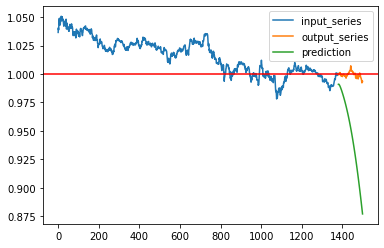

In [9]:
# train 샘플 훈련 성과 시각화해보기
# 1) 입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 정의
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

# 2) train data 중 sample_id idx에 해당하는 x_series로 모델을 학습한 후 y_series를 추론
x_series = train_x_array[sample,:,1]
y_series = train_y_array[sample,:,1]
plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), train_pred_array[0,:,0], label = 'prediction')
plt.legend()
plt.show()

In [13]:
train_pred_array

array([[[0.99097097],
        [0.99107701],
        [0.99103469],
        [0.99088627],
        [0.99066108],
        [0.99037796],
        [0.99005044],
        [0.98968726],
        [0.98929513],
        [0.98887837],
        [0.98844069],
        [0.98798496],
        [0.98751301],
        [0.98702687],
        [0.98652762],
        [0.98601645],
        [0.9854942 ],
        [0.98496145],
        [0.98441887],
        [0.98386663],
        [0.98330528],
        [0.98273504],
        [0.9821558 ],
        [0.98156792],
        [0.98097128],
        [0.98036611],
        [0.97975236],
        [0.97912991],
        [0.9784987 ],
        [0.97785902],
        [0.97721028],
        [0.97655284],
        [0.97588658],
        [0.97521114],
        [0.97452694],
        [0.97383332],
        [0.97313058],
        [0.97241867],
        [0.97169721],
        [0.97096628],
        [0.97022593],
        [0.96947575],
        [0.96871597],
        [0.96794635],
        [0.96716702],
        [0

In [11]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index

def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

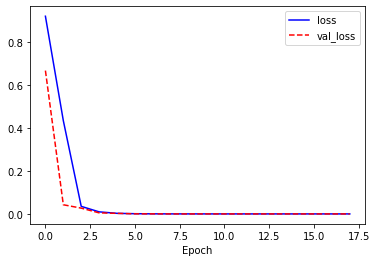

In [10]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
total_momey, total_momey_list = COIN(train_y_df,
                                     train_pred_array)
print(total_momey)

AttributeError: 'numpy.ndarray' object has no attribute 'set_index'

---

In [ ]:
# train_x_df의 자료들을 학습에 활용하게 될 경우:
# train_x_df를 sample_id을 기준으로 추출하는 방법
train_x_df = train_x_df[train_x_df.sample_id < 300]
train_y_df = train_y_df[train_y_df.sample_id < 300]